# LTI Map Abstraction example
A smaller version of the `adhs18` example that demonstrates similar features: 
 - abstraction of a LTI Gaussian system
 - interconnected MDPs for exploration
 - LTL synthesis

In [1]:
import numpy as np
import polytope as pc
from itertools import combinations
from collections import OrderedDict

import matplotlib.pyplot as plt
from matplotlib import patches

from best.abstraction.gridding import LTIAbstraction
from best.models.pomdp import POMDP, POMDPNetwork
from best.models.lti import LTI
from best.solvers.valiter import solve_ltl_cosafe

# Define the linear time invariant system
A = np.eye(2)
B = np.eye(2)
W = np.array([[0,0],[0,0.4]]) #2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None
sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

# How far away do we detect labels
sight_distance = 2

# Abstraction coarseness
eta = np.array([0.69294, 0.721])

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


In [2]:
# Define regions of interest for the labeling
regions = OrderedDict()
regions['target1'] = pc.box2poly(np.array([[-9, -6], [6, 9]]))
regions['target2'] = pc.box2poly(np.array([[6, 9], [6, 9]]))
regions['obstacle1'] = pc.box2poly(np.array([[0, 2], [-5, 2]]))
regions['obstacle2'] = pc.box2poly(np.array([[0, 2], [3, 10]]))

def close(poly, point, distance):
    # returns true if point within distance of poly
    if point is None:
        return False
    return np.all(poly.A.dot(point.flatten()) < poly.b + distance)

### Construct map MDPs

In [3]:
# label prior probabilities
p_list = [0.5, 0.6, 0.1, 0.3]

target_output = lambda n: ['init', 'true', 'false'][n]

map_mdp_list = [POMDP([np.eye(3), np.array([[0,p,1-p], [0,1,0], [0,0,1]])], 
                  input_names=['meas{}'.format(i)],
                  output_trans=target_output,
                  state_name='label{}'.format(i))
                for (i, p) in enumerate(p_list)]

### Construct abstraction

status: optimal
optimal epsilon 1.0000147592332758
optimal M [[1. 0.]
 [0. 1.]]
Optimal K [[-0.  0.]
 [ 0.  0.]]
MDP: (9,) inputs ('u_d',) --> 813 states s --> 813 outputs (s,xc)
nnz: 157295, sparsity: 0.026441818333722493


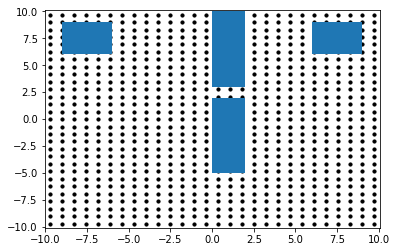

In [4]:
sys_lti_n = sys_lti.normalize()

abstr = LTIAbstraction(sys_lti_n, eta, un=3)

fig = plt.figure()
ax0 = fig.add_subplot(111)
abstr.plot(ax0)

# plot regions
for poly in regions.values():
    V = pc.extreme(poly)
    ax0.add_patch(patches.Polygon(V))

print (abstr.mdp)
print ('nnz: {}, sparsity: {}'.format(abstr.mdp.nnz, abstr.mdp.sparsity))

### Connect abstraction and map

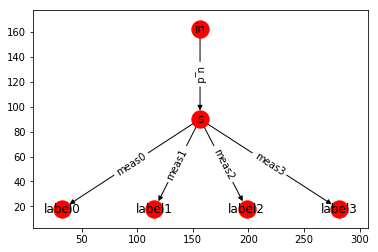

In [5]:
# mapping (s, x_d) -> 2^2^(meas1, meas2, meas3)
network = POMDPNetwork([abstr.mdp] + map_mdp_list)

network.add_connection(['(s,xc)'], 'meas0', lambda s_xc: {close(regions['target1'], s_xc[1], sight_distance)}  )
network.add_connection(['(s,xc)'], 'meas1', lambda s_xc: {close(regions['target2'], s_xc[1], sight_distance)} )
network.add_connection(['(s,xc)'], 'meas2', lambda s_xc: {close(regions['obstacle1'], s_xc[1], sight_distance)} )
network.add_connection(['(s,xc)'], 'meas3', lambda s_xc: {close(regions['obstacle2'], s_xc[1], sight_distance)} )

network.plot()

### Set up and solve LTL problem

In [6]:
formula = '! obstacle U sample'

def sample_predicate(s_xc, lbl_t1, lbl_t2):
    if s_xc[1] is None or np.any(np.abs(s_xc[1]) > 10):
        return {0}    
    cond1 = all(abstr.polytopic_predicate(s_xc[1], regions['target1'])) and lbl_t1 == 'true'
    cond2 = all(abstr.polytopic_predicate(s_xc[1], regions['target2'])) and lbl_t2 == 'true'

    return {cond1 or cond2}
    
def obstacle_predicate(s_xc, lbl_o1, lbl_o2):
    if s_xc[1] is None or np.any(np.abs(s_xc[1]) > 10):
        return {1}
    cond1 = any(abstr.polytopic_predicate(s_xc[1], regions['obstacle1'])) and lbl_o1 == 'true'
    cond2 = any(abstr.polytopic_predicate(s_xc[1], regions['obstacle2'])) and lbl_o2 == 'true'

    return {cond1 or cond2}

predicates = {'sample': (['(s,xc)', 'label0', 'label1'], sample_predicate),
              'obstacle': (['(s,xc)', 'label2', 'label3'],obstacle_predicate)}

pol = solve_ltl_cosafe(network, formula, predicates, delta=0.01)

finished after 5.43s and 72 iterations


### Define policy

In [7]:
# define a policy on top of mdp policy
def my_policy(x, mapstate):
    # x: current concrete state [x; y]
    x = np.array(x).reshape((2,1))
    
    lbl_t1 = mapstate[0]
    lbl_t2 = mapstate[1]
    lbl_ob1 = mapstate[2]
    lbl_ob2 = mapstate[3]

    aps = []
    
    if regions['target1'].contains(x) and lbl_t1 == 1 or \
       regions['target2'].contains(x) and lbl_t2 == 1:
        # we are in target region and a sample exists
        aps.append('sample')
        
    if regions['obstacle1'].contains(x) and lbl_ob1 == 1 or \
       regions['obstacle2'].contains(x) and lbl_ob2 == 1:
        # we are in obstacle region and not sure that there is no obstacle
        aps.append('obstacle')
        
    pol.report_aps(aps)
    
    s_ab = abstr.x_to_s(x)
            
    u_ab, curr_val = pol((s_ab,) + tuple(mapstate) )
    
    if curr_val > 0 and u_ab != -1:
        return abstr.interface(u_ab, s_ab, x)
    else:
        return np.array([[0], [0]])

def my_value(x):    
    s_ab = abstr.x_to_s(x)
    
    if s_ab is None:
        return 0

    _, val = pol((s_ab, 0, 0, 0, 0))
    return val

def my_policy_init(x):
    u = my_policy(x, (0,0,0,0))
    pol.reset()
    return u

pol.reset()

### Plot value function

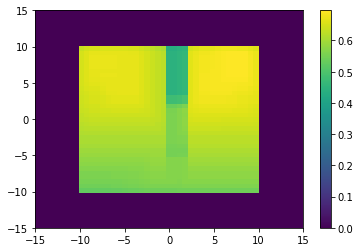

In [8]:
fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

values = np.array([my_value( np.array([x,y])) for (x,y) in zip(xi, yi)])

plt.pcolor(x_edge, y_edge, values.reshape((49,49)))
plt.colorbar()
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))
plt.show()

### Run a simulation

reached
reached
reached
reached
reached
reached


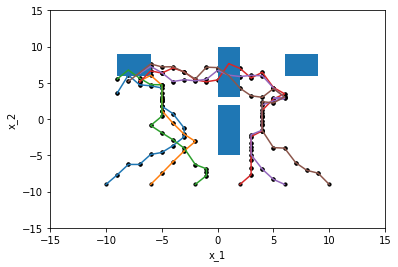

In [9]:
import scipy.linalg as scla
import matplotlib

np.random.seed(4)

time = 70
fig = plt.figure()
ax = fig.add_subplot(111)

# plot regions
for poly in regions.values():
    V = pc.extreme(poly)
    ax.add_patch(matplotlib.patches.Polygon(V))
    
realmap = [1, 2, 1, 2]   # true map state

Wsqrt = scla.sqrtm(sys_lti.W)
for xinit in range(-10, 11, 4):
    pol.reset()
    mapstate = [0, 0, 0, 0]
    xx = np.array([[xinit],[-9]])

    for t in range(time): 
        # current state
        xt = np.array(xx[:,-1]).reshape(2,1)
        # reveal map if within distance
        for i, poly in enumerate(regions.values()):
            if close(poly, xt, sight_distance):
                mapstate[i] = realmap[i]
        # next state
        ut = my_policy(xt, mapstate)
        wt = np.random.normal(0,1,size=(2,1))
        # update state
        xt1 = sys_lti.a.dot(xt)+sys_lti.b.dot(ut) + np.array(Wsqrt).dot(wt)

        xx = np.hstack([xx, xt1])

        if pol.finished() :
            print('reached')
            break

    if not pol.finished():
        print('not reached')

    plt.plot(xx[0,:], xx[1,:])
    plt.scatter(xx[0,:], xx[1,:], label='Finite states', color='k', s=10, marker="o")

plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

plt.xlabel('x_1') 
plt.ylabel('x_2') 
plt.show()